# Task 1 - Exploratory Data Analysis (EDA)

1. Conduct an EDA.
2. Create an interactive notebook(.ipynb file) in Python:
   - Outline the steps taken in the EDA process
   - Explain the purpose of each step
   - Explain the conclusions drawn from each step
   - Explain the interpretation of the various statistics generated and how they impact your analysis
   - Generate clear, meaningful, and understandable visualizations that support your findings
   - Organize the notebook so that is it clear and easy to understand


In [1]:
%matplotlib inline

# import required libraries
import os
import requests
import pandas as pd
import sqlite3
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import yaml

from urllib.parse import urlsplit

## Common functions defined and to be used

In [2]:
# Function to generate and save simple count plot graph based on input feature
def plot_countplot(feature, data_set):
    '''
    Plot countplot based on required input feature.
    Dataset is set to df unless input otherwise.
    Countplot image is saved in ./img/eda folder
    '''
    g=sns.countplot(x=feature,data=data_set)
    g.set(title=f'Distribution count of {feature}')
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    g.bar_label(g.containers[0])

    img_name = "eda_countplot_" + feature + ".png"
    img_path = "./img/eda/"
    fig = g.get_figure()
    fig.savefig(img_path+img_name)

In [3]:
# Function to generate and save simple histplot graph based on input feature
def plot_histplot(feature, feature_description, feature_name, binwidth=10):
    '''
    Plot histplot based on required input feature.
    Binwidth is set to 10 unless input otherwise.
    Histplot title to contain input feature_description.
    Histplot image is saved in ./img/eda folder with input feature_name as part of file name
    '''
    g=sns.histplot(feature, binwidth=binwidth)
    g.set(title=f'Histogram plot of {feature_description}')
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    g.bar_label(g.containers[0])

    img_name = "eda_histplot_" + feature_name + ".png"
    img_path = "./img/eda/"
    fig = g.get_figure()
    fig.savefig(img_path+img_name)

In [4]:
# Function to generate and save simple boxplot graph based on input feature
def plot_boxplot(feature, feature_description, feature_name):
    '''
    Plot boxplot based on required input feature.
    Boxplot title to contain input feature_description.
    Boxplot image is saved in ./img/eda folder with input feature_name as part of file name
    '''
    g=sns.boxplot(feature)
    g.set(title=f'Box plot of {feature_description}')

    img_name = "eda_boxplot_" + feature_name + ".png"
    img_path = "./img/eda/"
    fig = g.get_figure()
    fig.savefig(img_path+img_name)

In [5]:
# Function to find the 99%-confidence interval to determine the acceptable range of the numerical feature
def feature_confidence_interval(feature_df):
    '''
    Find the 99%-confidence interval to determine the acceptable range of the input numerical feature dataframe.
    Output will be the lower limit and upper limit
    '''
    # Calculate the mean and standard deviation of the feature
    mean = feature_df.mean()
    std = feature_df.std()
    n = len(feature_df)

    # Calculate the margin of error
    margin_of_error = 1.96 * (std / np.sqrt(n))

    # Calculate the lower and upper bounds of the confidence interval
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)

    return confidence_interval

In [6]:
# Function to drop the row(s) with temperature in °C of value more than input max limit.
def drop_temp_degree_more_than_max_limit(max_limit, dataset):
    '''
    Function will drop rows from input dataset that are more than input max_limit for temperature in degree and return datframe after dropping

    input args:
        max_limit(int): max limit threshold to drop rows of temperature in degree
        dataset(Dataframe): dataframe to process
    
    output:
        dataset with rows dropped which are more than max_limit for temperature in degree
    '''
    df = dataset
    
    for index, row in df.iterrows():
        if ("°C" in row['Temperature']) & (float(row['Temperature'].split(' ')[0]) > max_limit):
            df.drop(index, inplace=True)

    return df

In [7]:
# Function to convert Temperature from Fahrenheit (°F) to Celsius (°C)
# Formula for converting °F to °C: °C = (°F − 32) × 5/9 
def convert_fahrenheit_to_celsius(dataset):
    '''
    Function look into dataset['Temperature']
    If dataset['Temperature'] has "°F", convert to Celsius by °C = (°F - 32) * 5/9 e.g. "230.9 °C" will become 110.5 as float 
    Else dataset['Temperature'] will contain "°C", then keep only the numerical value e.g. "113.3 °C" will keep only 113.3 as float

    Dataset['Temperature'] will be just of type float, all in Celsius.

    return dataset
    '''

    df = dataset

    for index, row in df.iterrows():
        if "°F" in row['Temperature']:
            temp_f = float(row['Temperature'].split(' ')[0]) 
            temp_c = (temp_f - 32.0) * 5.0/9.0
            df.at[index,'Temperature'] = temp_c
        else:
            df.at[index,'Temperature'] = float(row['Temperature'].split(' ')[0])

    df.astype({'Temperature': 'float'}).dtypes
    
    
    # df['Temperature'] = df['Temperature'].apply(lambda x: float((x.split(' ')[0] - 32.0) * 5.0/9.0) if "°F" in x else float(x.split(' ')[0]))

    return df


In [8]:
# assigning Normal to null Membership
def fill_na_membership_to_Normal(dataset):
    '''
    Fill null Membership in dataset to "Normal"
    '''
    df = dataset
    df['Membership'].fillna('Normal', inplace=True)
    return df

## Dataset

In [9]:
# Data url
data_url = 'https://techassessment.blob.core.windows.net/aiap13-assessment-data/failure.db'

response = requests.get(data_url, stream=True)

# Save data into ./data folder
data_input_file_folder = './data'
data_input_file = 'failure.db'
data_file_path = os.path.join(data_input_file_folder, data_input_file)

with open(data_file_path, 'wb') as file:
    file.write(response.content)

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(data_file_path)

with con:
    sql_table = "failure"
    sql_query = f"SELECT * from {sql_table}"
    df_original = pd.read_sql_query(sql_query, con)

# make a copy of orginal data for processing
df = df_original.copy()

# Verify that result of SQL query is stored in the dataframe
print(df.head())


                                 Car ID          Model  Color Temperature  \
0  137b948a-c99f-4afa-a2a7-9ef65ae51e8f  Model 5, 2022   Blue    110.3 °C   
1  3395a182-7e76-4fb3-94ba-5163d8f4e6b0  Model 3, 2022  Black    110.4 °C   
2  8c6a8e5b-d869-4665-b739-819c9e4a2070  Model 3, 2022   Grey    110.3 °C   
3  ff864366-fe5e-409e-9b2f-8fe440d8cc5b  Model 3, 2022  Black    110.4 °C   
4  10484506-1be0-4a86-8dbc-b8b2092b93b2  Model 3, 2022  White    230.7 °C   

    RPM           Factory   Usage  Fuel consumption Membership  Failure A  \
0  1551  Shang Hai, China  Medium             659.7     Normal          0   
1  1408  Shang Hai, China  Medium             705.3    Premium          1   
2  1498  Shang Hai, China     Low             670.7    Premium          0   
3  1433   Berlin, Germany    High             630.6    Premium          1   
4  1408     New York, U.S    High             660.9     Normal          0   

   Failure B  Failure C  Failure D  Failure E  
0          0          0   

In [10]:
print("There are {a} observations, {b} attributes (features)".format(a=df.shape[0], b=df.shape[1]))

There are 10081 observations, 14 attributes (features)


In [11]:
# show the attributes involved, the types and any missing values accordingly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            10081 non-null  object 
 1   Model             10081 non-null  object 
 2   Color             10081 non-null  object 
 3   Temperature       10081 non-null  object 
 4   RPM               10081 non-null  int64  
 5   Factory           10081 non-null  object 
 6   Usage             10081 non-null  object 
 7   Fuel consumption  10081 non-null  float64
 8   Membership        9697 non-null   object 
 9   Failure A         10081 non-null  int64  
 10  Failure B         10081 non-null  int64  
 11  Failure C         10081 non-null  int64  
 12  Failure D         10081 non-null  int64  
 13  Failure E         10081 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


At first glance, only Membership has missing values. The rest of the features has no missing values.

In [12]:
# feature names before processing
df_features = list(df.columns)
df_features

['Car ID',
 'Model',
 'Color',
 'Temperature',
 'RPM',
 'Factory',
 'Usage',
 'Fuel consumption',
 'Membership',
 'Failure A',
 'Failure B',
 'Failure C',
 'Failure D',
 'Failure E']

## Univariate Analysis

### Univariate Analysis: Car ID

In [13]:
# Check whether there are any duplicates
df[df.duplicated()].count()

Car ID              81
Model               81
Color               81
Temperature         81
RPM                 81
Factory             81
Usage               81
Fuel consumption    81
Membership          80
Failure A           81
Failure B           81
Failure C           81
Failure D           81
Failure E           81
dtype: int64

In [14]:
# Car ID are supposed to be unique. Check whether there are any duplicate for Car ID.
df[df['Car ID'].duplicated()].count()

Car ID              81
Model               81
Color               81
Temperature         81
RPM                 81
Factory             81
Usage               81
Fuel consumption    81
Membership          80
Failure A           81
Failure B           81
Failure C           81
Failure D           81
Failure E           81
dtype: int64

There are 81 duplicates of Car ID which is supposed to be unique. 

These account for the duplicates in the entire dataframe.

In data processing, need to drop all these duplicates.

In [15]:
# Drop duplicates in dataframe 
df.drop_duplicates(inplace=True)
df[df.duplicated()].count()

Car ID              0
Model               0
Color               0
Temperature         0
RPM                 0
Factory             0
Usage               0
Fuel consumption    0
Membership          0
Failure A           0
Failure B           0
Failure C           0
Failure D           0
Failure E           0
dtype: int64

In [16]:
# check whether all duplicates dropped off
#df[df.duplicated()].count().all()==0

#assert df.isnull().sum().all() == 0, "Dataset still contains duplicates"
assert df[df.duplicated()].count().all()==0, "Dataset still contains duplicates"

### Univariate Analysis: Model

In [17]:
# look into model
df['Model'].value_counts(normalize=True)

Model 3, 2016    0.0586
Model 3, 2020    0.0562
Model 3, 2021    0.0560
Model 3, 2012    0.0556
Model 3, 2014    0.0552
Model 3, 2018    0.0541
Model 3, 2019    0.0532
Model 3, 2013    0.0528
Model 3, 2015    0.0526
Model 3, 2017    0.0509
Model 3, 2022    0.0315
Model 5, 2018    0.0314
Model 5, 2020    0.0306
Model 5, 2014    0.0289
Model 5, 2016    0.0288
Model 5, 2012    0.0274
Model 5, 2017    0.0267
Model 5, 2013    0.0263
Model 5, 2015    0.0247
Model 5, 2021    0.0245
Model 5, 2019    0.0244
Model 3, 2011    0.0201
Model 5, 2022    0.0170
Model 7, 2014    0.0103
Model 7, 2016    0.0097
Model 7, 2018    0.0095
Model 7, 2020    0.0094
Model 7, 2015    0.0090
Model 7, 2019    0.0090
Model 7, 2017    0.0088
Model 7, 2012    0.0086
Model 7, 2013    0.0084
Model 7, 2021    0.0084
Model 5, 2011    0.0082
Model 7, 2022    0.0060
Model 3, 2010    0.0031
Model 7, 2011    0.0027
Model 5, 2010    0.0007
Model 7, 2010    0.0005
Model 3, 2009    0.0001
Model 5, 2009    0.0001
Name: Model, dty

The Model column is actually comprises of Model 3, 5, 7 with year added.
Better to split Model column into Model and Year respectively.

In [18]:
df['Year']=df['Model'].str.split(',',n=1,expand=True)[1].astype(int)
df['Year'].value_counts(normalize=True)

2016    0.0971
2020    0.0962
2018    0.0950
2014    0.0944
2012    0.0916
2021    0.0889
2013    0.0875
2019    0.0866
2017    0.0864
2015    0.0863
2022    0.0545
2011    0.0310
2010    0.0043
2009    0.0002
Name: Year, dtype: float64

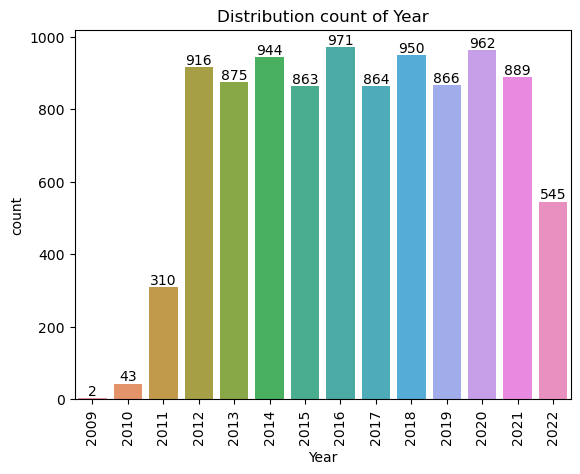

In [19]:
# countplot for Year using plot_countplot(feature data_set=df) function
plot_countplot(feature='Year', data_set=df)

In [20]:
df['Year'].min()

2009

All car models are 2009 and above. Use 2009 as minimum limit check for 'Year'.

In [21]:
# leave model in Model column to indicate as categorical feature
df['Model']=df['Model'].str.split(',',n=1,expand=True)[0]
df['Model'].value_counts(normalize=True)

Model 3    0.6000
Model 5    0.2997
Model 7    0.1003
Name: Model, dtype: float64

In [22]:
# Null count in model and year column
print(f"Null count in Model: {df['Model'].isnull().sum()}")
print(f"Null count in Year: {df['Year'].isnull().sum()}")


Null count in Model: 0
Null count in Year: 0


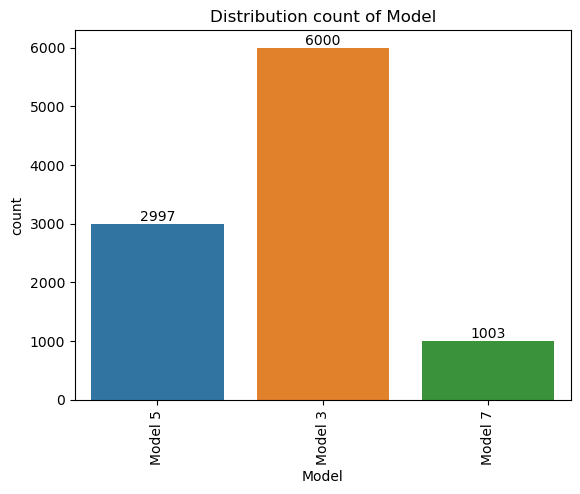

In [23]:
# countplot for Model using plot_countplot(feature, data_set=df) function
plot_countplot(feature='Model', data_set=df)

In [24]:
# Model classes
model_class = df['Model'].value_counts().keys().to_list()
model_class

['Model 3', 'Model 5', 'Model 7']

In [25]:
df.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Year
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,2022
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,Model 3,Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0,2022
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,Model 3,Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0,2022
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,Model 3,Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0,2022
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,Model 3,White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0,2022


### Univariate Analysis: Color

In [26]:
df['Color'].value_counts(normalize=True)

White    0.5568
Red      0.1159
Blue     0.1129
Grey     0.1086
Black    0.1058
Name: Color, dtype: float64

In [27]:
color_class = df['Color'].value_counts().keys().to_list()
color_class

['White', 'Red', 'Blue', 'Grey', 'Black']

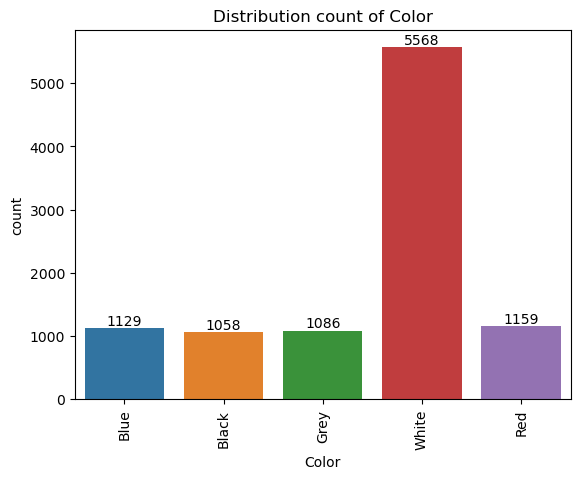

In [28]:
# countplot for Color using plot_countplot(feature, data_set=df) function
plot_countplot(feature='Color', data_set=df)

Color logically will not affect the failure of the car. Can drop column during data processing

### Univariate Analysis: Temperature

In [29]:
df['Temperature'].value_counts(normalize=True)

110.2 °C    0.0785
110.3 °C    0.0582
110.4 °C    0.0534
110.6 °C    0.0489
110.1 °C    0.0324
             ...  
110.0 °C    0.0003
230.7 °C    0.0001
278.2 °F    0.0001
138.7 °C    0.0001
274.9 °F    0.0001
Name: Temperature, Length: 125, dtype: float64

There is a mix of °C and °F.
Add a column to indicate the metric unit used

In [30]:
# separate metric unit for temperature
df_temp_mixed = df.copy()
df_temp_mixed['Temperature_unit']=df['Temperature'].str.split(' ',n=1,expand=True)[1]  # n=1 to limit to 1 split only based on space, expand=True to return DataFrame, not lists of strings
df_temp_mixed['Temperature_unit'].value_counts(normalize=True)

°C    0.783
°F    0.217
Name: Temperature_unit, dtype: float64

In [31]:
# separate metric unit from temperature, convert to float
df_temp_mixed['Temperature']=df['Temperature'].str.split(' ',n=1,expand=True)[0].astype(float)
df_temp_mixed['Temperature'].value_counts(normalize=True)

110.2    0.0785
110.3    0.0582
110.4    0.0534
110.6    0.0489
110.1    0.0324
          ...  
136.8    0.0006
110.0    0.0003
278.2    0.0001
138.7    0.0001
274.9    0.0001
Name: Temperature, Length: 124, dtype: float64

#### Univariate Analysis: Temperature (°C)

/tmp/ipykernel_12816/3419948463.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


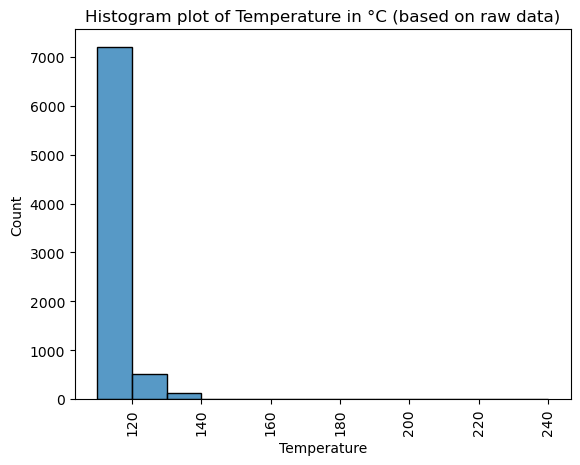

In [32]:
# check histplot distribution of °C cases based on raw data given
feature = df_temp_mixed[df_temp_mixed['Temperature_unit']=='°C']['Temperature']
feature_description = "Temperature in °C (based on raw data)"
feature_name = "temp_celsius_raw"
plot_histplot(feature, feature_description, feature_name)

From histogram, there seems to be some outliers. Check next for outlier cases.

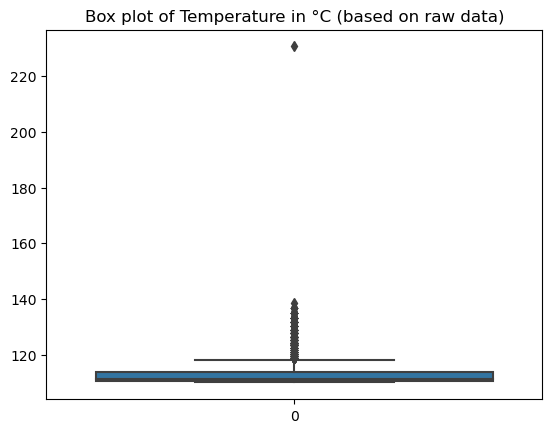

In [33]:
# check boxplot distribution of °C cases based on raw data given
feature = df_temp_mixed[df_temp_mixed['Temperature_unit']=='°C']['Temperature']
feature_description = "Temperature in °C (based on raw data)"
feature_name = "temp_celsius_raw"
plot_boxplot(feature, feature_description, feature_name)

There is clearly outlier from the boxplot figure. Check the acceptable range of temperature in degree

In [34]:
# check the numerical distribution of temperature in degree of the raw dataset
df_temp_mixed[df_temp_mixed['Temperature_unit']=='°C']['Temperature'].describe()

count    7830.000000
mean      113.117139
std         4.707411
min       110.000000
25%       110.400000
50%       111.400000
75%       113.600000
max       230.700000
Name: Temperature, dtype: float64

75th percentile is 113.
There are outlier in Temperature for those under °C. 

In [35]:
#check if there are super outlier cases (above 113) for Temperature (°C)
df1 = df_temp_mixed[(df_temp_mixed['Temperature_unit']=='°C') & (df_temp_mixed['Temperature'] > 113)]
df1.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Year,Temperature_unit
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,Model 3,White,230.7,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0,2022,°C
3260,b325aa18-94d5-4bb6-957d-d3dec790dae3,Model 5,White,113.1,2068,"Shang Hai, China",High,690.1,None,0,0,0,0,0,2013,°C
3261,73335792-6337-461d-a270-56f115b22050,Model 7,White,113.1,1469,"Berlin, Germany",Low,796.9,Premium,0,0,0,0,0,2013,°C
3262,527865bf-cffe-479a-92bb-673be5eb0f8b,Model 3,Blue,113.1,1558,"Shang Hai, China",Medium,682.5,None,0,0,0,0,0,2013,°C
3263,21da2c87-f0d9-454e-a8d6-0b6d7805254f,Model 3,White,113.1,1344,"Shang Hai, China",High,606.1,None,0,0,0,0,0,2013,°C


There is only one super outlier (way above the 75th perentile 113°C).

This outlier case of value 230.7°C might be due to wrong entry. It might be  of value 230.7°F instead of  of value 230.7°C.

Safe to assume that such case is rare.

Safe to use 150 as the max temperature check for those °C field in preprocessing.

Any temperature in °C of value more than 150 can be dropped off.

In [36]:
# Drop the row(s) with temperature in °C of value more than 150
max_limit=150
drop_index = df_temp_mixed[(df_temp_mixed['Temperature_unit']=='°C') & (df_temp_mixed['Temperature'] > max_limit)].index
df_temp_mixed.drop(drop_index, inplace=True)
df_temp_mixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            9999 non-null   object 
 1   Model             9999 non-null   object 
 2   Color             9999 non-null   object 
 3   Temperature       9999 non-null   float64
 4   RPM               9999 non-null   int64  
 5   Factory           9999 non-null   object 
 6   Usage             9999 non-null   object 
 7   Fuel consumption  9999 non-null   float64
 8   Membership        9616 non-null   object 
 9   Failure A         9999 non-null   int64  
 10  Failure B         9999 non-null   int64  
 11  Failure C         9999 non-null   int64  
 12  Failure D         9999 non-null   int64  
 13  Failure E         9999 non-null   int64  
 14  Year              9999 non-null   int64  
 15  Temperature_unit  9999 non-null   object 
dtypes: float64(2), int64(7), object(7)
memory 

/tmp/ipykernel_12816/3419948463.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


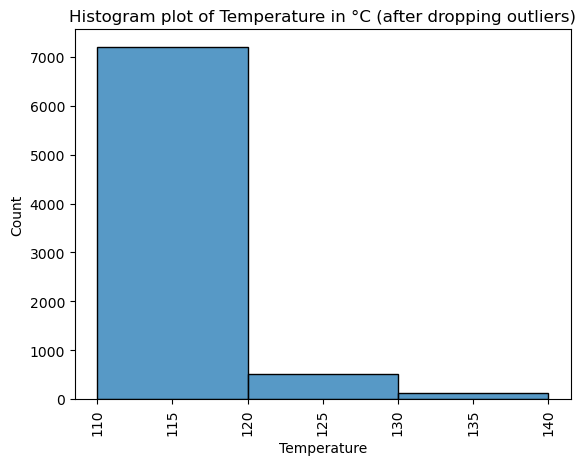

In [37]:
# check histplot distribution of °C cases after dropping off outliers
feature = df_temp_mixed[df_temp_mixed['Temperature_unit']=='°C']['Temperature']
feature_description = "Temperature in °C (after dropping outliers)"
feature_name = "temp_celsius_no_outliers"
plot_histplot(feature, feature_description, feature_name)

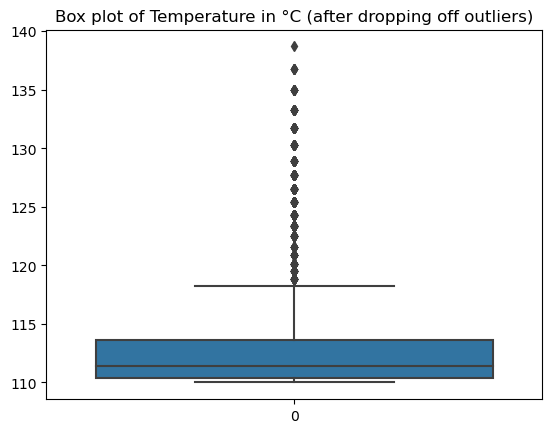

In [38]:
# check boxplot distribution of °C cases after dropping off outliers
feature = df_temp_mixed[df_temp_mixed['Temperature_unit']=='°C']['Temperature']
feature_description = "Temperature in °C (after dropping off outliers)"
feature_name = "temp_degree_no_outliers"
plot_boxplot(feature, feature_description, feature_name)

In [39]:
# check whether rows dropped off successfully: max should be lesser than 150
df_temp_mixed[df_temp_mixed['Temperature_unit']=='°C']['Temperature'].describe()

count    7829.000000
mean      113.102120
std         4.516208
min       110.000000
25%       110.400000
50%       111.400000
75%       113.600000
max       138.700000
Name: Temperature, dtype: float64

Set upper_limit for °C = 150.

Anything more than that most probably are errors.



Though there are still seemmingly outliers, these are more distributed so will leave it as it is. 

These temperature "outliers" might be the cause of Failure A, B, C, D.

#### Univariate Analysis: Temperature (°F)

/tmp/ipykernel_12816/3419948463.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


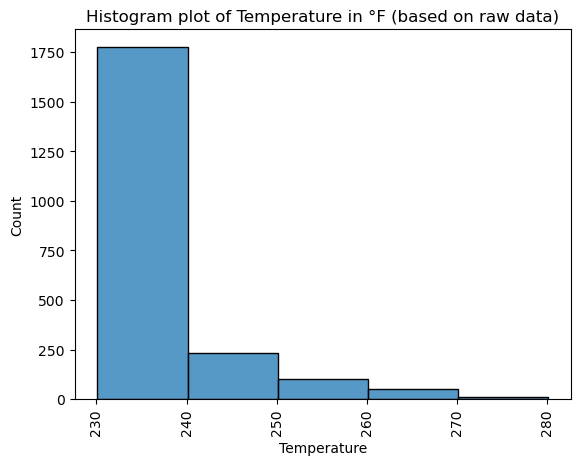

In [40]:
# check histplot distribution of °F cases based on raw data given
feature = df_temp_mixed[df_temp_mixed['Temperature_unit']=='°F']['Temperature']
feature_description = "Temperature in °F (based on raw data)"
feature_name = "temp_fahrenheit_raw"
plot_histplot(feature, feature_description, feature_name)

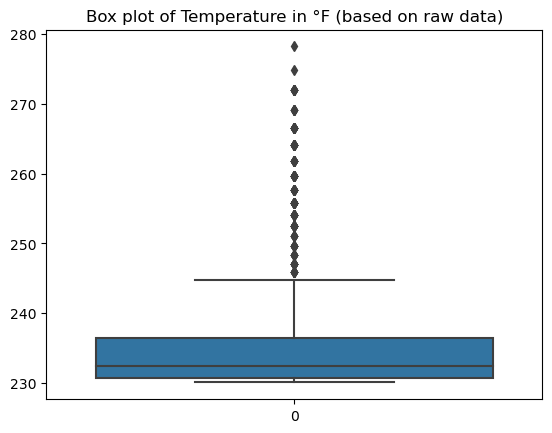

In [41]:
# check boxplot distribution of °F cases based on raw data given
feature = df_temp_mixed[df_temp_mixed['Temperature_unit']=='°F']['Temperature'].reset_index(drop=True)
feature_description = "Temperature in °F (based on raw data)"
feature_name = "temp_fahrenheit_raw"
plot_boxplot(feature, feature_description, feature_name)

In [42]:
# check whether rows dropped off successfully: max should be lesser than 150
df_temp_mixed[df_temp_mixed['Temperature_unit']=='°F']['Temperature'].describe()

count    2170.000000
mean      235.622535
std         8.166316
min       230.100000
25%       230.800000
50%       232.400000
75%       236.500000
max       278.200000
Name: Temperature, dtype: float64

Set lower_limit for °F = 220.

Upper limit can be more and cause failures

Though there are still seemmingly outliers, these are more distributed so will leave it as it is. 

These temperature "outliers" might be the cause of Failure A, B, C, D.

In [43]:
df_temp_mixed[df_temp_mixed['Temperature_unit']=='°C']['Temperature']

0       110.3
1       110.4
2       110.3
3       110.4
5       110.3
        ...  
9994    110.6
9995    110.6
9996    110.6
9997    110.6
9999    110.6
Name: Temperature, Length: 7829, dtype: float64

In [44]:
df_temp_mixed[df_temp_mixed['Temperature_unit']=='°F']['Temperature']

10      230.8
11      230.9
17      230.9
24      231.1
29      231.1
        ...  
9979    230.8
9985    230.9
9988    231.1
9990    231.0
9998    231.1
Name: Temperature, Length: 2170, dtype: float64

#### Univariate Analysis: Temperature (Convert all °F to °C)



In [45]:
# Drop the super outlier row(s) with temperature in °C of value more than 150
df = drop_temp_degree_more_than_max_limit(max_limit=150.0, dataset=df)
df.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Year
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,2022
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,Model 3,Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0,2022
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,Model 3,Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0,2022
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,Model 3,Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0,2022
5,3b5e4310-9f3f-4c4d-92c3-ec09fa36f772,Model 5,White,110.3 °C,1425,"Shang Hai, China",Medium,691.8,Premium,0,0,0,0,0,2021


In [46]:
# convert Temperature from °F to °C
df = convert_fahrenheit_to_celsius(dataset=df)
df.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Year
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,Blue,110.3,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,2022
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,Model 3,Black,110.4,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0,2022
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,Model 3,Grey,110.3,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0,2022
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,Model 3,Black,110.4,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0,2022
5,3b5e4310-9f3f-4c4d-92c3-ec09fa36f772,Model 5,White,110.3,1425,"Shang Hai, China",Medium,691.8,Premium,0,0,0,0,0,2021


/tmp/ipykernel_12816/3419948463.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


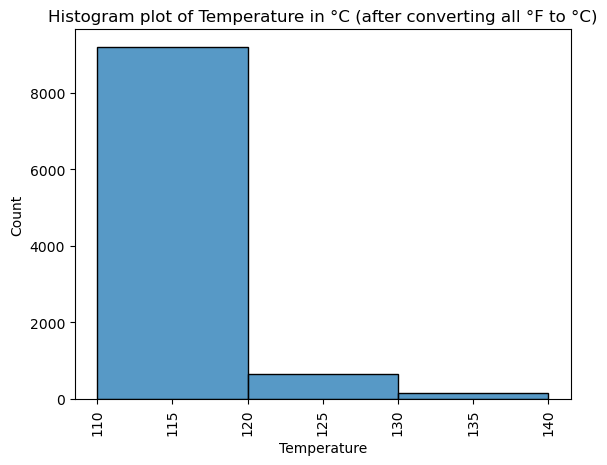

In [47]:
# check histplot distribution of all °C (after converting all °F to °C) cases based on raw data given
feature = df['Temperature']
feature_description = "Temperature in °C (after converting all °F to °C)"
feature_name = "temp_celsius_all"
plot_histplot(feature, feature_description, feature_name)

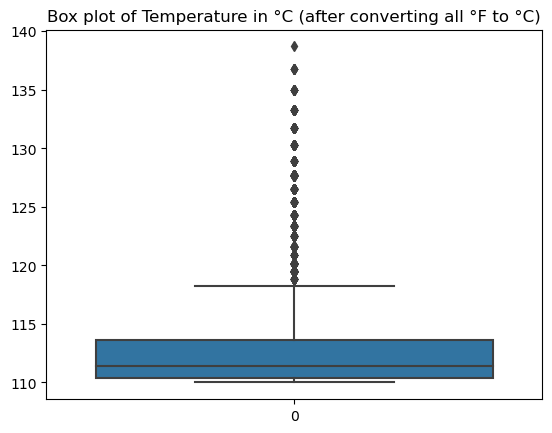

In [48]:
# check boxplot distribution of °F cases based on raw data given
feature = df['Temperature']
feature_description = "Temperature in °C (after converting all °F to °C)"
feature_name = "temp_celsius_all"
plot_boxplot(feature, feature_description, feature_name)

In [49]:
# check whether rows dropped off successfully: max should be lesser than 150
df['Temperature'].describe()

count     9999.0
unique     121.0
top        110.2
freq       785.0
Name: Temperature, dtype: float64

In [50]:
# check max, min of Temperature
print(f"Min: {df['Temperature'].min()}, Max: {df['Temperature'].max()}")

Min: 110.0, Max: 138.7


In [51]:
# check confidence_interval of Temperature
ci_temp = feature_confidence_interval(df['Temperature'])
print(ci_temp)

(113.01818270550373, 113.19539420773808)


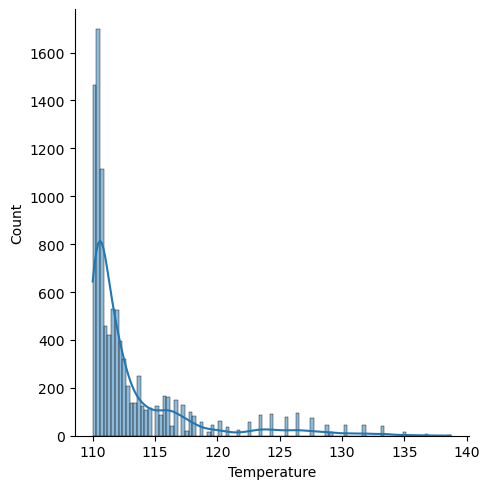

In [52]:
# check histplot distribution of Temperature
sns.displot(df['Temperature'], kde=True)

Use minmaxscaler on Temperature for pipeline

Use lower limit=100, upper_limit=150 as a data check for Temperature during the data checking process

### Univariate Analysis: RPM

/tmp/ipykernel_12816/3419948463.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


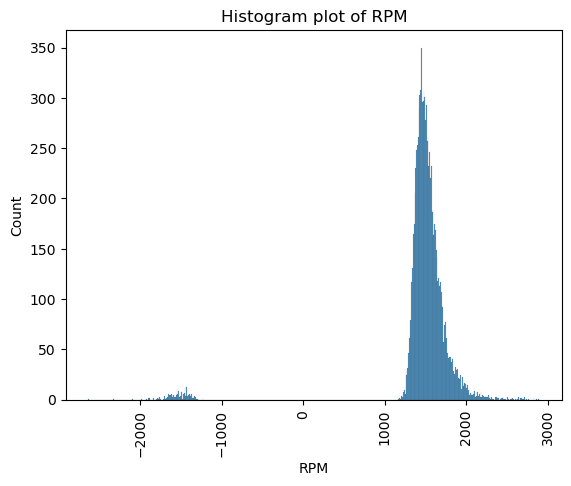

In [53]:
# check histplot distribution of RPM
feature = df['RPM']
feature_description = "RPM"
feature_name = "rpm"
plot_histplot(feature, feature_description, feature_name)

In [54]:
df[df['RPM']<0].count()

Car ID              220
Model               220
Color               220
Temperature         220
RPM                 220
Factory             220
Usage               220
Fuel consumption    220
Membership          211
Failure A           220
Failure B           220
Failure C           220
Failure D           220
Failure E           220
Year                220
dtype: int64

In [55]:
df_rpm_neg = df[df['RPM']<0]
df_rpm_neg.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Year
46,2cb649e9-ce6e-4cef-9206-45992d3b92ae,Model 5,Black,110.5,-1843,"New York, U.S",Low,741.5,None,0,0,0,0,0,2016
66,05fc6931-1619-4077-976e-26caf0f7ddab,Model 5,Black,110.611111,-1679,"New York, U.S",High,697.9,Normal,0,0,0,0,0,2013
82,66b79dfb-3724-413a-84cd-0c792cbb3889,Model 3,White,110.6,-1453,"Shang Hai, China",Low,679.8,Premium,0,0,0,0,0,2021
126,2c1810f2-62ad-4249-a6e1-33b773c9db92,Model 3,White,110.6,-1329,"Berlin, Germany",Medium,669.9,None,0,0,0,0,0,2016
243,334f6375-4485-4734-9ce6-c8e3a2740cc3,Model 3,White,110.333333,-1442,"New York, U.S",High,656.6,Premium,0,0,0,0,0,2012


In [56]:
df_rpm_pos = df[df['RPM']>0]
df_rpm_pos.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Year
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,Blue,110.3,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,2022
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,Model 3,Black,110.4,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0,2022
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,Model 3,Grey,110.3,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0,2022
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,Model 3,Black,110.4,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0,2022
5,3b5e4310-9f3f-4c4d-92c3-ec09fa36f772,Model 5,White,110.3,1425,"Shang Hai, China",Medium,691.8,Premium,0,0,0,0,0,2021


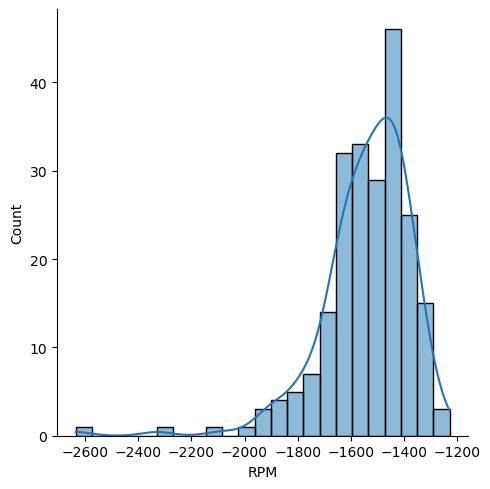

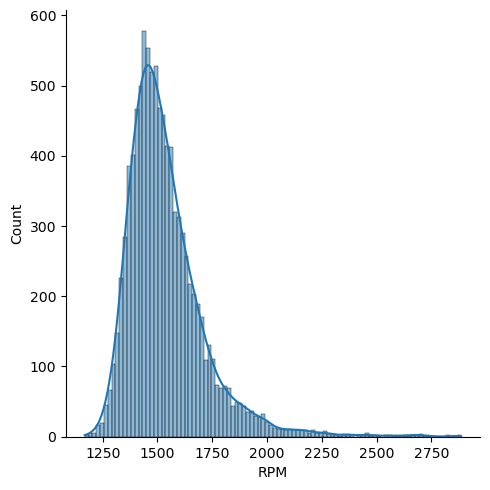

In [57]:
sns.displot(df_rpm_neg['RPM'], kde=True)
sns.displot(df_rpm_pos['RPM'], kde=True)
plt.show()

The distribution between positive and negative RPM are different.

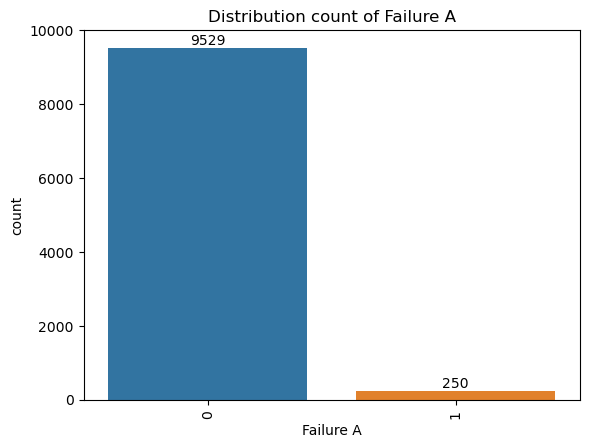

In [58]:
# countplot for Factory using plot_countplot(feature, data_set=df) function
plot_countplot(feature='Failure A', data_set=df_rpm_pos)

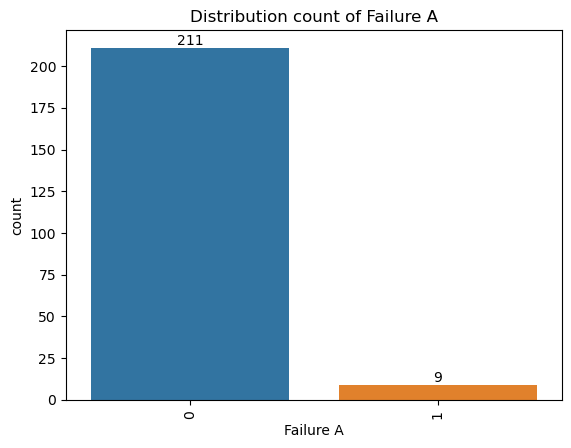

In [59]:
# countplot for Factory using plot_countplot(feature, data_set=df) function
plot_countplot(feature='Failure A', data_set=df_rpm_neg)

In [60]:
df_rpm_neg['Failure A'].value_counts(normalize=True)*100

0    95.909091
1     4.090909
Name: Failure A, dtype: float64

In [61]:
df_rpm_pos['Failure A'].value_counts(normalize=True)*100

0    97.443501
1     2.556499
Name: Failure A, dtype: float64

Proportion for Failure A in negtive RPM:
 0    95.909091
1     4.090909
Name: Failure A, dtype: float64
Proportion for Failure A in positive RPM:
 0    97.443501
1     2.556499
Name: Failure A, dtype: float64
Proportion for Failure B in negtive RPM:
 0    97.727273
1     2.272727
Name: Failure B, dtype: float64
Proportion for Failure B in positive RPM:
 0    98.169547
1     1.830453
Name: Failure B, dtype: float64
Proportion for Failure C in negtive RPM:
 0    99.090909
1     0.909091
Name: Failure C, dtype: float64
Proportion for Failure C in positive RPM:
 0    96.850394
1     3.149606
Name: Failure C, dtype: float64
Proportion for Failure D in negtive RPM:
 0    96.818182
1     3.181818
Name: Failure D, dtype: float64
Proportion for Failure D in positive RPM:
 0    97.576439
1     2.423561
Name: Failure D, dtype: float64
Proportion for Failure E in negtive RPM:
 0    99.090909
1     0.909091
Name: Failure E, dtype: float64
Proportion for Failure E in positive RPM:
 0    97.320789
1 

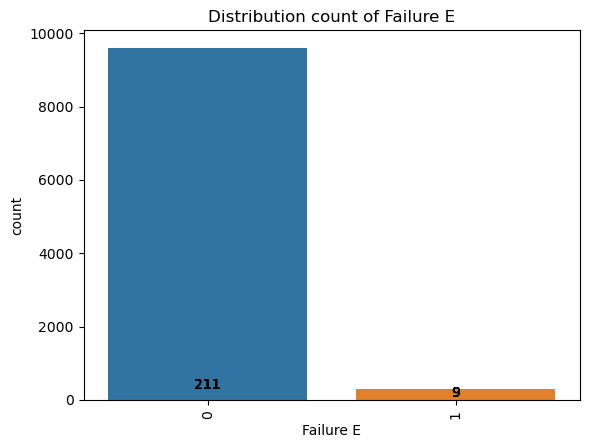

In [62]:
# countplot for Factory using plot_countplot(feature, data_set=df) function
def rpm_failure_proportion(feature):
    plot_countplot(feature, data_set=df_rpm_neg)
    plot_countplot(feature, data_set=df_rpm_pos)
    print(f"Proportion for {feature} in negtive RPM:\n {df_rpm_neg[feature].value_counts(normalize=True)*100}")
    print(f"Proportion for {feature} in positive RPM:\n {df_rpm_pos[feature].value_counts(normalize=True)*100}")

feature_failure = ['Failure A','Failure B','Failure C','Failure D','Failure E']
#feature_failure = ['Failure D']

for feature in feature_failure:
    rpm_failure_proportion(feature)

Looks like the distribution of failures in positive or negative rpm is roughly the same.

In [63]:
# assume normal distribution
from statsmodels.stats.proportion import proportions_ztest

def proportion_failure_pos_neg_rpm(feature):
# observed proportions and sample sizes
    count1 = df_rpm_neg[feature].value_counts()[1]
    nobs1 = len(df_rpm_neg[feature])
    count2 = df_rpm_pos[feature].value_counts()[1]
    nobs2 = len(df_rpm_pos[feature])

    print(f"For {feature}:")
    print(count1, nobs1)
    print(count2, nobs2)

    # perform the proportions z-test
    stat, pval = proportions_ztest([count1, count2], [nobs1, nobs2])

    # check the p-value
    if pval < 0.05:
        print(f"The two proportions for {feature} are likely different (p = {round(pval,2)})")
    else:
        print(f"The two proportions for {feature} are likely the same (p = {round(pval,2)})")

feature_failure = ['Failure A','Failure B','Failure C','Failure D','Failure E']
for feature in feature_failure:
    proportion_failure_pos_neg_rpm(feature)

For Failure A:
9 220
250 9779
The two proportions for Failure A are likely the same (p = 0.16)
For Failure B:
5 220
179 9779
The two proportions for Failure B are likely the same (p = 0.63)
For Failure C:
2 220
308 9779
The two proportions for Failure C are likely the same (p = 0.06)
For Failure D:
7 220
237 9779
The two proportions for Failure D are likely the same (p = 0.47)
For Failure E:
2 220
262 9779
The two proportions for Failure E are likely the same (p = 0.11)


In [64]:
#for non-normal distribution

from scipy.stats import binom_test

def proportion_failure_pos_neg_rpm(feature):
# observed proportions and sample sizes
    count1 = df_rpm_neg[feature].value_counts()[1]
    nobs1 = len(df_rpm_neg[feature])
    count2 = df_rpm_pos[feature].value_counts()[1]
    nobs2 = len(df_rpm_pos[feature])

    print(f"For {feature}:")
    print(count1, nobs1)
    print(count2, nobs2)

    # perform the Z-test
    pval = binom_test(count1, nobs1, count2/nobs2)

    # check the p-value
    if pval < 0.05:
        print(f"The two proportions for {feature} are likely different (p = {round(pval,2)})")
    else:
        print(f"The two proportions for {feature} are likely the same (p = {round(pval,2)})")

feature_failure = ['Failure A','Failure B','Failure C','Failure D','Failure E']
for feature in feature_failure:
    proportion_failure_pos_neg_rpm(feature)

For Failure A:
9 220
250 9779
The two proportions for Failure A are likely the same (p = 0.19)
For Failure B:
5 220
179 9779
The two proportions for Failure B are likely the same (p = 0.61)
For Failure C:
2 220
308 9779
The two proportions for Failure C are likely the same (p = 0.05)
For Failure D:
7 220
237 9779
The two proportions for Failure D are likely the same (p = 0.38)
For Failure E:
2 220
262 9779
The two proportions for Failure E are likely the same (p = 0.14)


The proportion of failures for both positive and negative is likely the same based on Binomial Test. So it does not sugggest that negative rpm will give rise to failures significantly. It might just suggest its running in the opposite direction. Thus, we can try absolute instead.

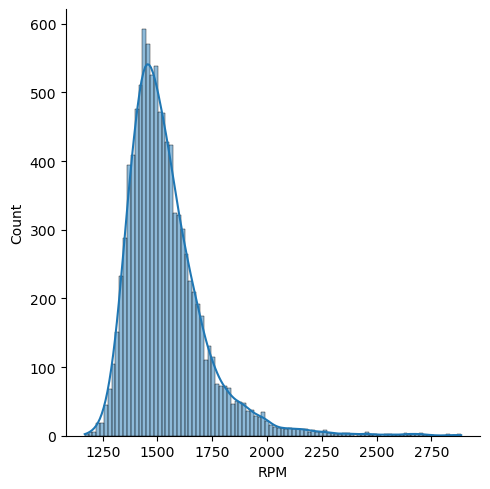

In [65]:
df_rpm_abs = df
df_rpm_abs['RPM'] = abs(df_rpm_abs['RPM'])
sns.displot(df_rpm_abs['RPM'], kde=True)
plt.show()

In [66]:
#for non-normal distribution

from scipy.stats import binom_test

def proportion_failure_neg_abs_rpm(feature):
# observed proportions and sample sizes
    count1 = df_rpm_neg[feature].value_counts()[1]
    nobs1 = len(df_rpm_neg[feature])
    count2 = df_rpm_abs[feature].value_counts()[1]
    nobs2 = len(df_rpm_abs[feature])

    print(f"For {feature}:")
    print(count1, nobs1)
    print(count2, nobs2)

    # perform the Z-test
    pval = binom_test(count1, nobs1, count2/nobs2)

    # check the p-value
    if pval < 0.05:
        print(f"The two proportions for {feature} are likely different (p = {round(pval,2)})")
    else:
        print(f"The two proportions for {feature} are likely the same (p = {round(pval,2)})")

feature_failure = ['Failure A','Failure B','Failure C','Failure D','Failure E']
for feature in feature_failure:
    proportion_failure_neg_abs_rpm(feature)

For Failure A:
9 220
259 9999
The two proportions for Failure A are likely the same (p = 0.19)
For Failure B:
5 220
184 9999
The two proportions for Failure B are likely the same (p = 0.61)
For Failure C:
2 220
310 9999
The two proportions for Failure C are likely the same (p = 0.08)
For Failure D:
7 220
244 9999
The two proportions for Failure D are likely the same (p = 0.51)
For Failure E:
2 220
264 9999
The two proportions for Failure E are likely the same (p = 0.14)


In [67]:
#for non-normal distribution

from scipy.stats import binom_test

def proportion_failure_pos_abs_rpm(feature):
# observed proportions and sample sizes
    count1 = df_rpm_pos[feature].value_counts()[1]
    nobs1 = len(df_rpm_pos[feature])
    count2 = df_rpm_abs[feature].value_counts()[1]
    nobs2 = len(df_rpm_abs[feature])

    print(f"For {feature}:")
    print(count1, nobs1)
    print(count2, nobs2)

    # perform the Z-test
    pval = binom_test(count1, nobs1, count2/nobs2)

    # check the p-value
    if pval < 0.05:
        print(f"The two proportions for {feature} are likely different (p = {round(pval,2)})")
    else:
        print(f"The two proportions for {feature} are likely the same (p = {round(pval,2)})")

feature_failure = ['Failure A','Failure B','Failure C','Failure D','Failure E']
for feature in feature_failure:
    proportion_failure_pos_abs_rpm(feature)

For Failure A:
250 9779
259 9999
The two proportions for Failure A are likely the same (p = 0.87)
For Failure B:
179 9779
184 9999
The two proportions for Failure B are likely the same (p = 1.0)
For Failure C:
308 9779
310 9999
The two proportions for Failure C are likely the same (p = 0.77)
For Failure D:
237 9779
244 9999
The two proportions for Failure D are likely the same (p = 0.95)
For Failure E:
262 9779
264 9999
The two proportions for Failure E are likely the same (p = 0.8)


The proportion of failures in positive and absolute RPM are likely the same.

The proportion of failures in negative and absolute RPM are likely the same.

Thus, use absolute RPM then minmaxscaler in pipeline.

Due to the distribution, no need to check the confidence interval of RPM

### Univariate Analysis: Factory

In [68]:
df['Factory'].isnull().sum()

0

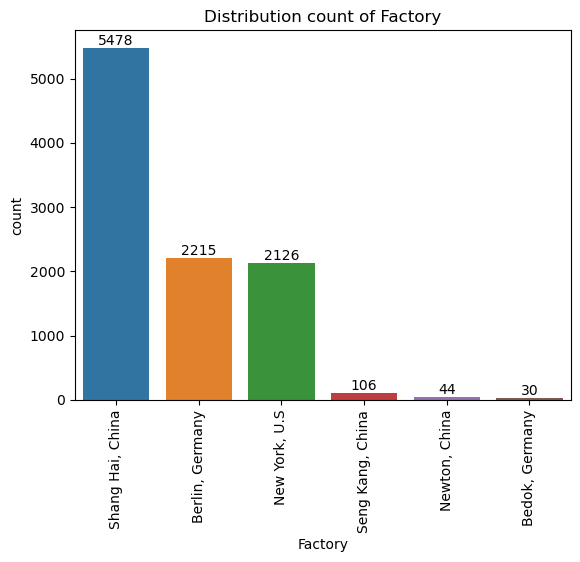

In [69]:
# countplot for Factory using plot_countplot(feature, data_set=df) function
plot_countplot(feature='Factory', data_set=df)

In [70]:
# Factory classes
model_class = df['Factory'].value_counts().keys().to_list()
model_class

['Shang Hai, China',
 'Berlin, Germany',
 'New York, U.S',
 'Seng Kang, China',
 'Newton, China',
 'Bedok, Germany']

### Univariate Analysis: Usage

In [71]:
df['Usage'].isnull().sum()

0

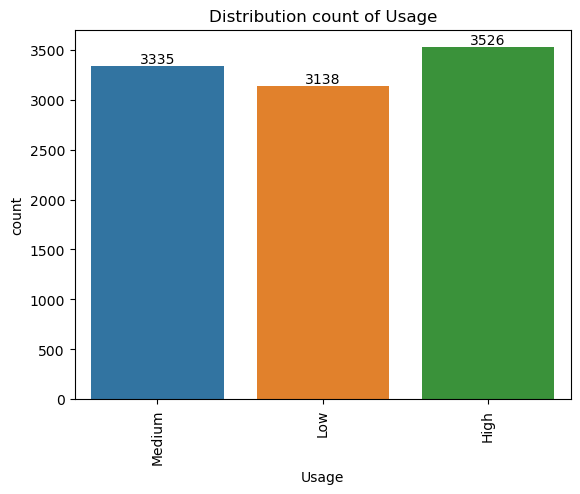

In [72]:
# countplot for Usage using plot_countplot(feature, data_set=df) function
plot_countplot(feature='Usage', data_set=df)

In [73]:
# Usage classes
model_class = df['Usage'].value_counts().keys().to_list()
model_class

['High', 'Medium', 'Low']

### Univariate Analysis: Fuel consumption

In [74]:
df['Fuel consumption'].isnull().sum()

0

/tmp/ipykernel_12816/3419948463.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


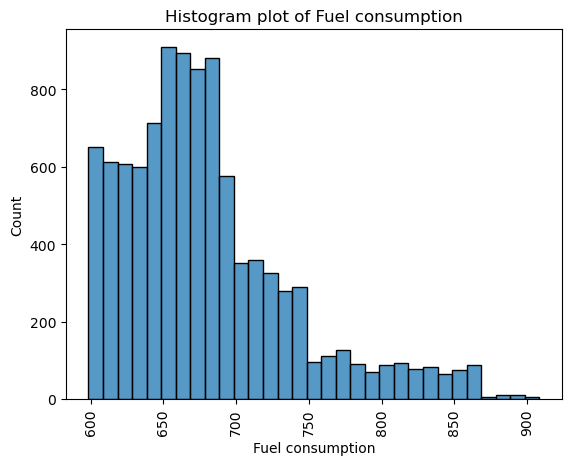

In [75]:
# check histplot distribution of Fuel consumption
feature = df['Fuel consumption']
feature_description = "Fuel consumption"
feature_name = "fuel_consumption"
plot_histplot(feature, feature_description, feature_name)

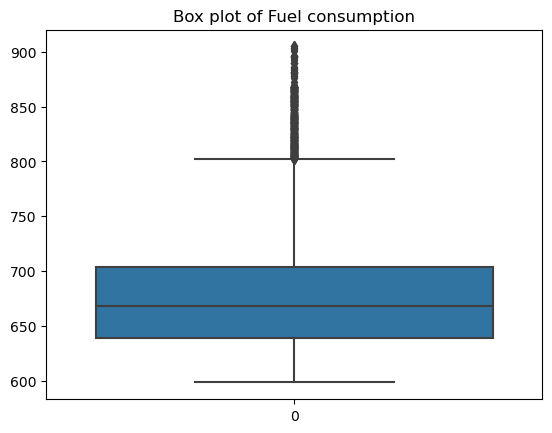

In [76]:
# check boxplot distribution of °F cases based on raw data given
feature = df['Fuel consumption']
feature_description = "Fuel consumption"
feature_name = "fuel_consumption"
plot_boxplot(feature, feature_description, feature_name)

Since distribution is skewed, use MinMaxScaler in pipeline to process "Fuel consumption".

In [77]:
# check whether rows dropped off successfully: max should be lesser than 150
df['Fuel consumption'].describe()

count    9999.000000
mean      679.458846
std        58.442323
min       598.500000
25%       638.850000
50%       668.500000
75%       704.200000
max       904.800000
Name: Fuel consumption, dtype: float64

In [78]:
# check confidence_interval of Temperature
ci_fuel = feature_confidence_interval(df['Fuel consumption'])
print(ci_fuel)

(678.3133190668085, 680.6043727023683)


Use lower limit=580, upper_limit=920 as a data check for Fuel consumption during the data checking process

### Univariate Analysis: Membership

In [79]:
# check for NA observations in Membership
print(f"Percentage of null observation in Membership: {round(df['Membership'].isnull().sum() * 100 / len(df), 2)}%")

Percentage of null observation in Membership: 3.83%


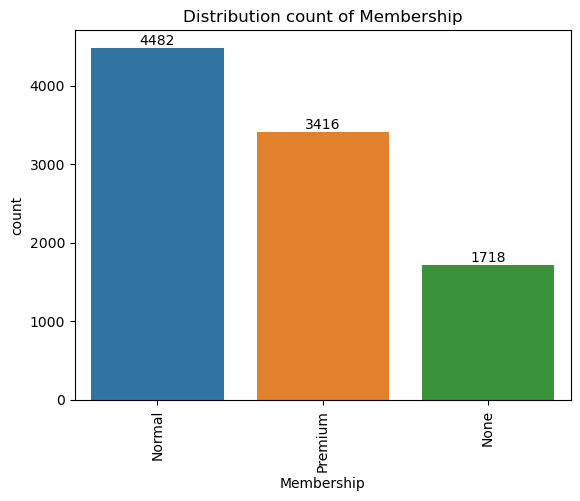

In [80]:
# countplot for Membership using plot_countplot(feature, data_set=df) function
plot_countplot(feature='Membership', data_set=df)

In [81]:
# check the year for those which Membership is null
df[df['Membership'].isnull()]['Year'].value_counts()

2018    88
2020    80
2019    78
2021    74
2022    63
Name: Year, dtype: int64

The car model years for which Membership is null are all lesser than 5 years, that is to say that the car owners of this group would hae purchased it for less than 5 years.

Since car owners are automatically subscribed with “Normal” membership for the first five years after car purchase and "Normal" membership is the mode of the distribution, the null Membership can be assigned "Normal".

In [82]:
# assigning Normal to null Membership
def fill_na_membership_to_Normal(dataset):
    '''
    Fill null membership to Normal
    '''
    return dataset['Membership'].fillna('Normal', inplace=True)

fill_na_membership_to_Normal(df)


In [83]:
assert df['Membership'].isnull().sum() == 0

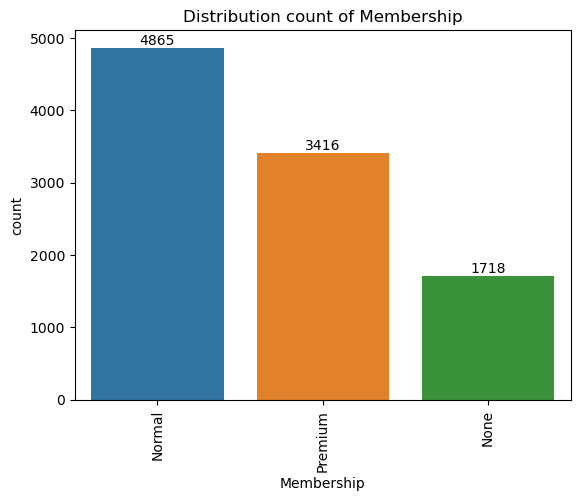

In [84]:
# countplot for Membership using plot_countplot(feature, data_set=df) function
plot_countplot(feature='Membership', data_set=df)


In [85]:
# Membership classes
membership_class = df['Membership'].value_counts().keys().to_list()
membership_class

['Normal', 'Premium', 'None']

In [86]:
# check whether all features containing null are taken care of.
df.isnull().sum()

Car ID              0
Model               0
Color               0
Temperature         0
RPM                 0
Factory             0
Usage               0
Fuel consumption    0
Membership          0
Failure A           0
Failure B           0
Failure C           0
Failure D           0
Failure E           0
Year                0
dtype: int64

### Univariate Analysis: Failure A

In [87]:
features_target = ['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']
print(features_target)

['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']


Failure A
Null count of df[Failure A]: 0
0    9740
1     259
Name: Failure A, dtype: int64


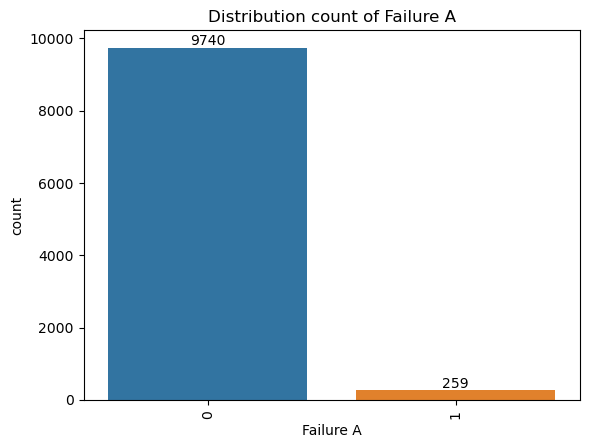

Failure B
Null count of df[Failure B]: 0
0    9815
1     184
Name: Failure B, dtype: int64


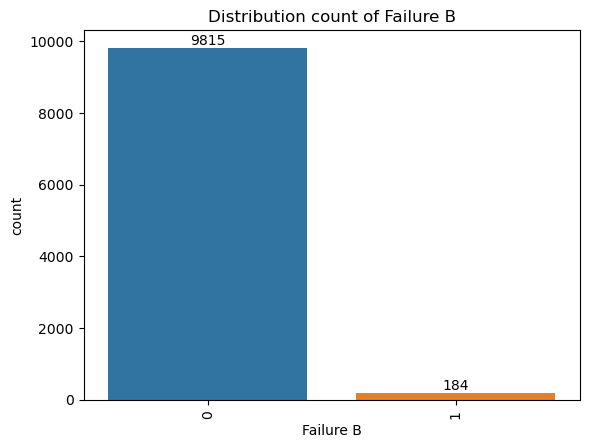

Failure C
Null count of df[Failure C]: 0
0    9689
1     310
Name: Failure C, dtype: int64


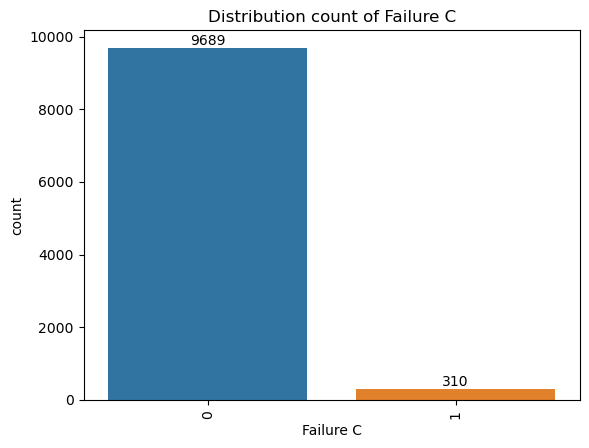

Failure D
Null count of df[Failure D]: 0
0    9755
1     244
Name: Failure D, dtype: int64


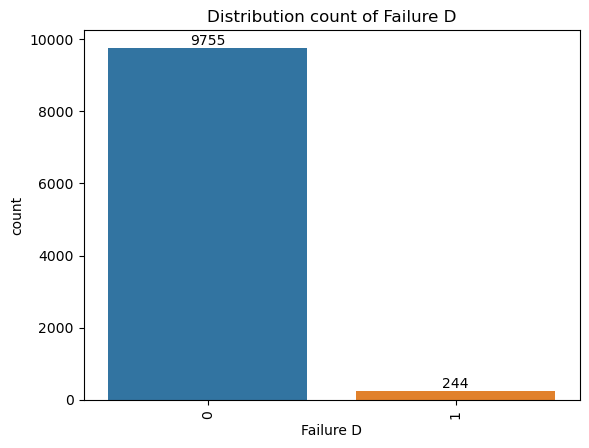

Failure E
Null count of df[Failure E]: 0
0    9735
1     264
Name: Failure E, dtype: int64


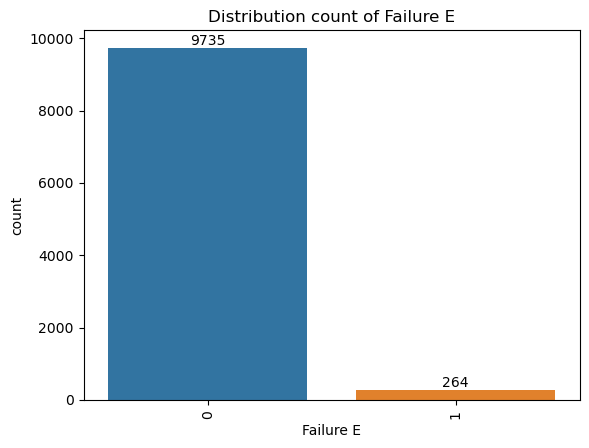

In [88]:
# check Membership features
for col in features_target:
    print(col)
    print(f"Null count of df[{col}]: {df[col].isnull().sum()}")
    print(df[col].value_counts())
    plot_countplot(feature=col, data_set=df)
    plt.show()


Failure C has the highest number of 1. Use Failure C to stratify when splitting processed data into training and test set

array([[<AxesSubplot: title={'center': 'RPM'}>,
        <AxesSubplot: title={'center': 'Fuel consumption'}>,
        <AxesSubplot: title={'center': 'Failure A'}>],
       [<AxesSubplot: title={'center': 'Failure B'}>,
        <AxesSubplot: title={'center': 'Failure C'}>,
        <AxesSubplot: title={'center': 'Failure D'}>],
       [<AxesSubplot: title={'center': 'Failure E'}>,
        <AxesSubplot: title={'center': 'Year'}>, <AxesSubplot: >]],
      dtype=object)

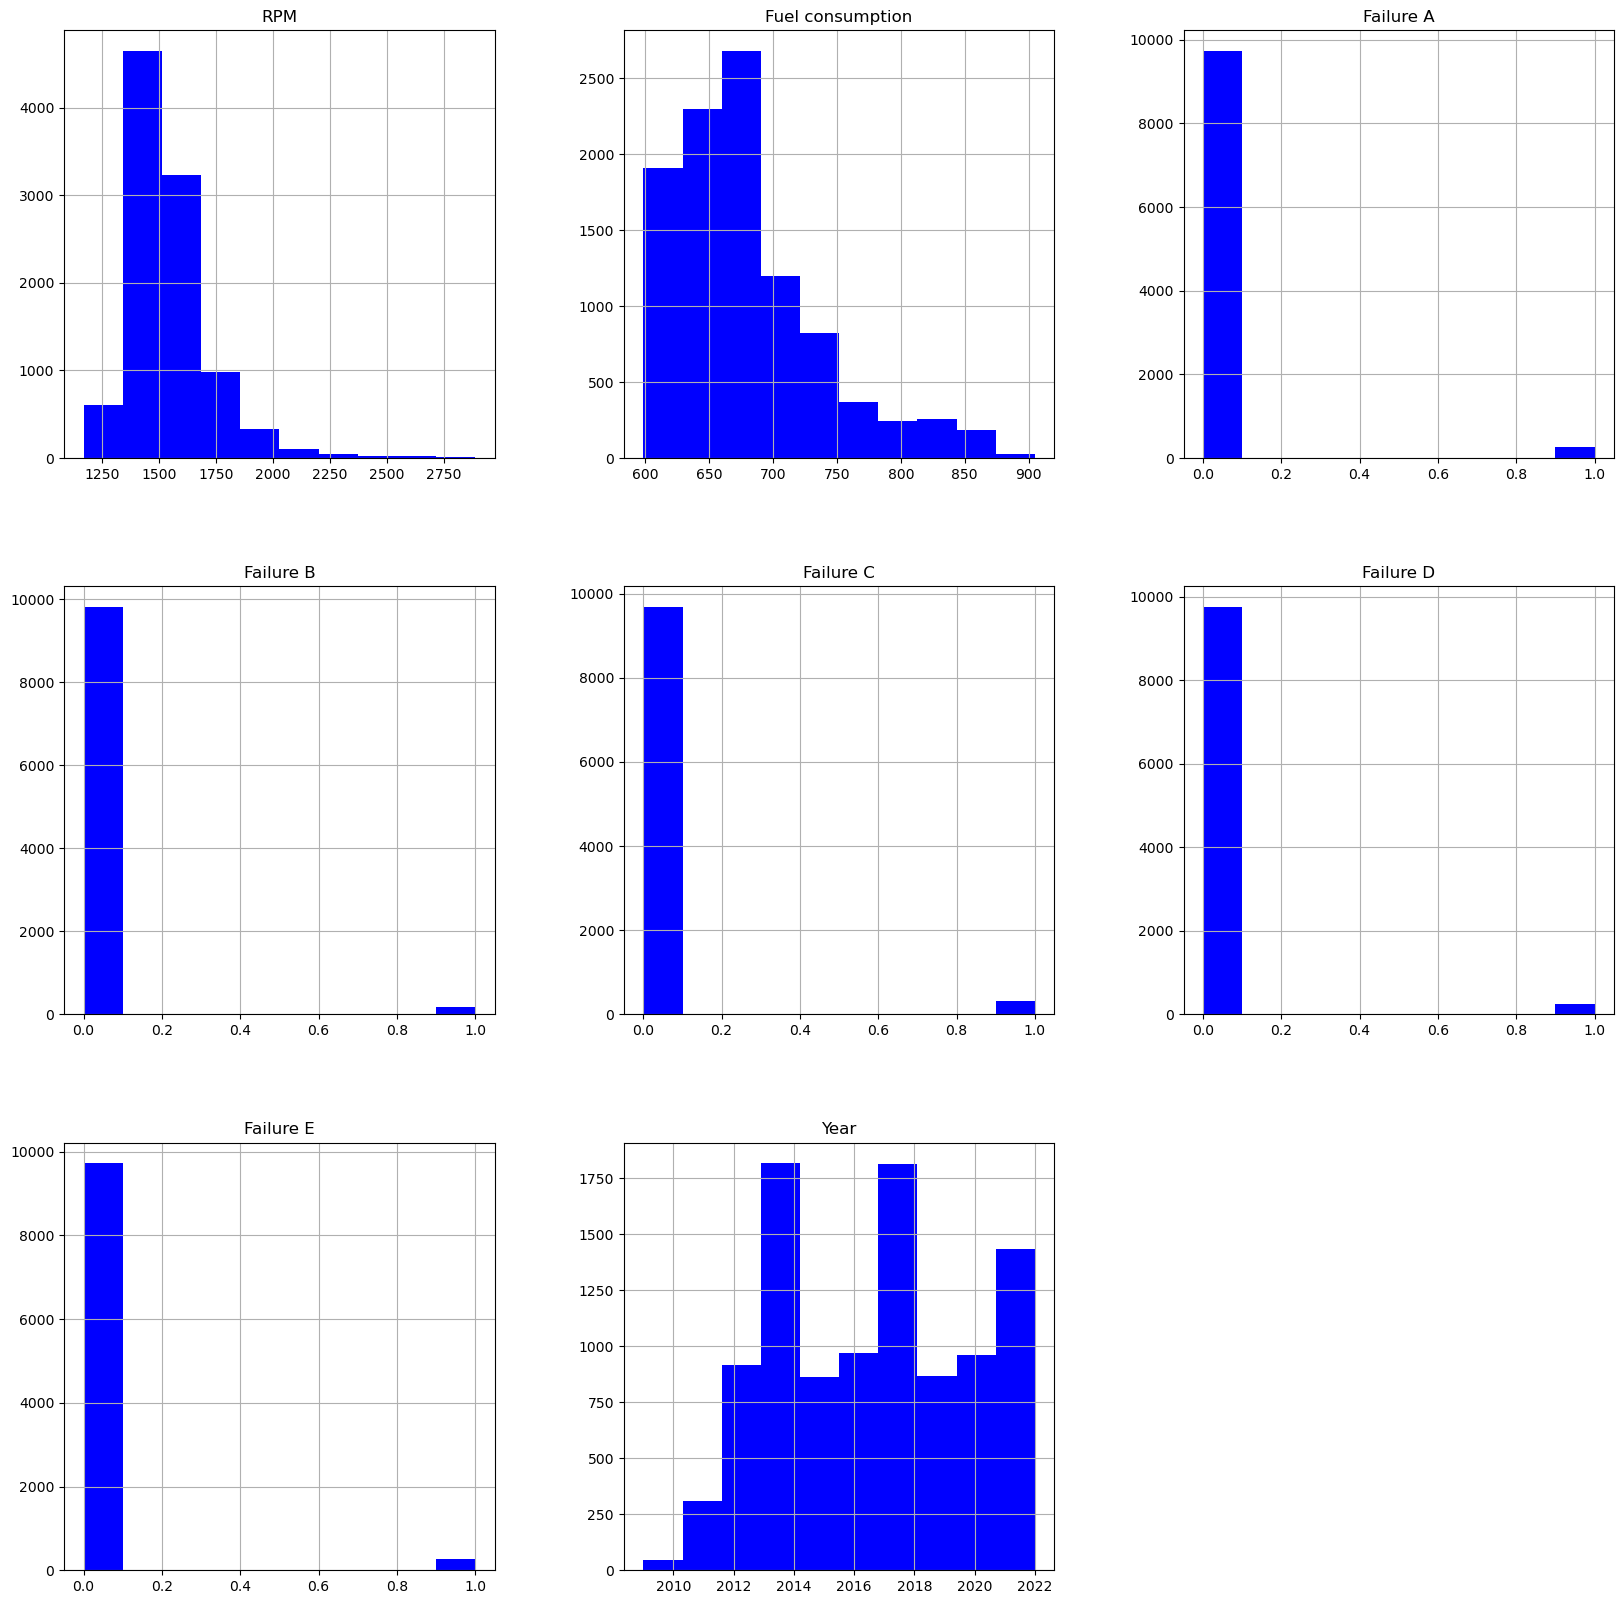

In [89]:
# ???? decide whether to present this ???? 
# quick overview of the distribution of the attributes - needed
df.hist(figsize = (20,20), color = 'b')

# Explore relationship between variables

### Overivew of pairplot

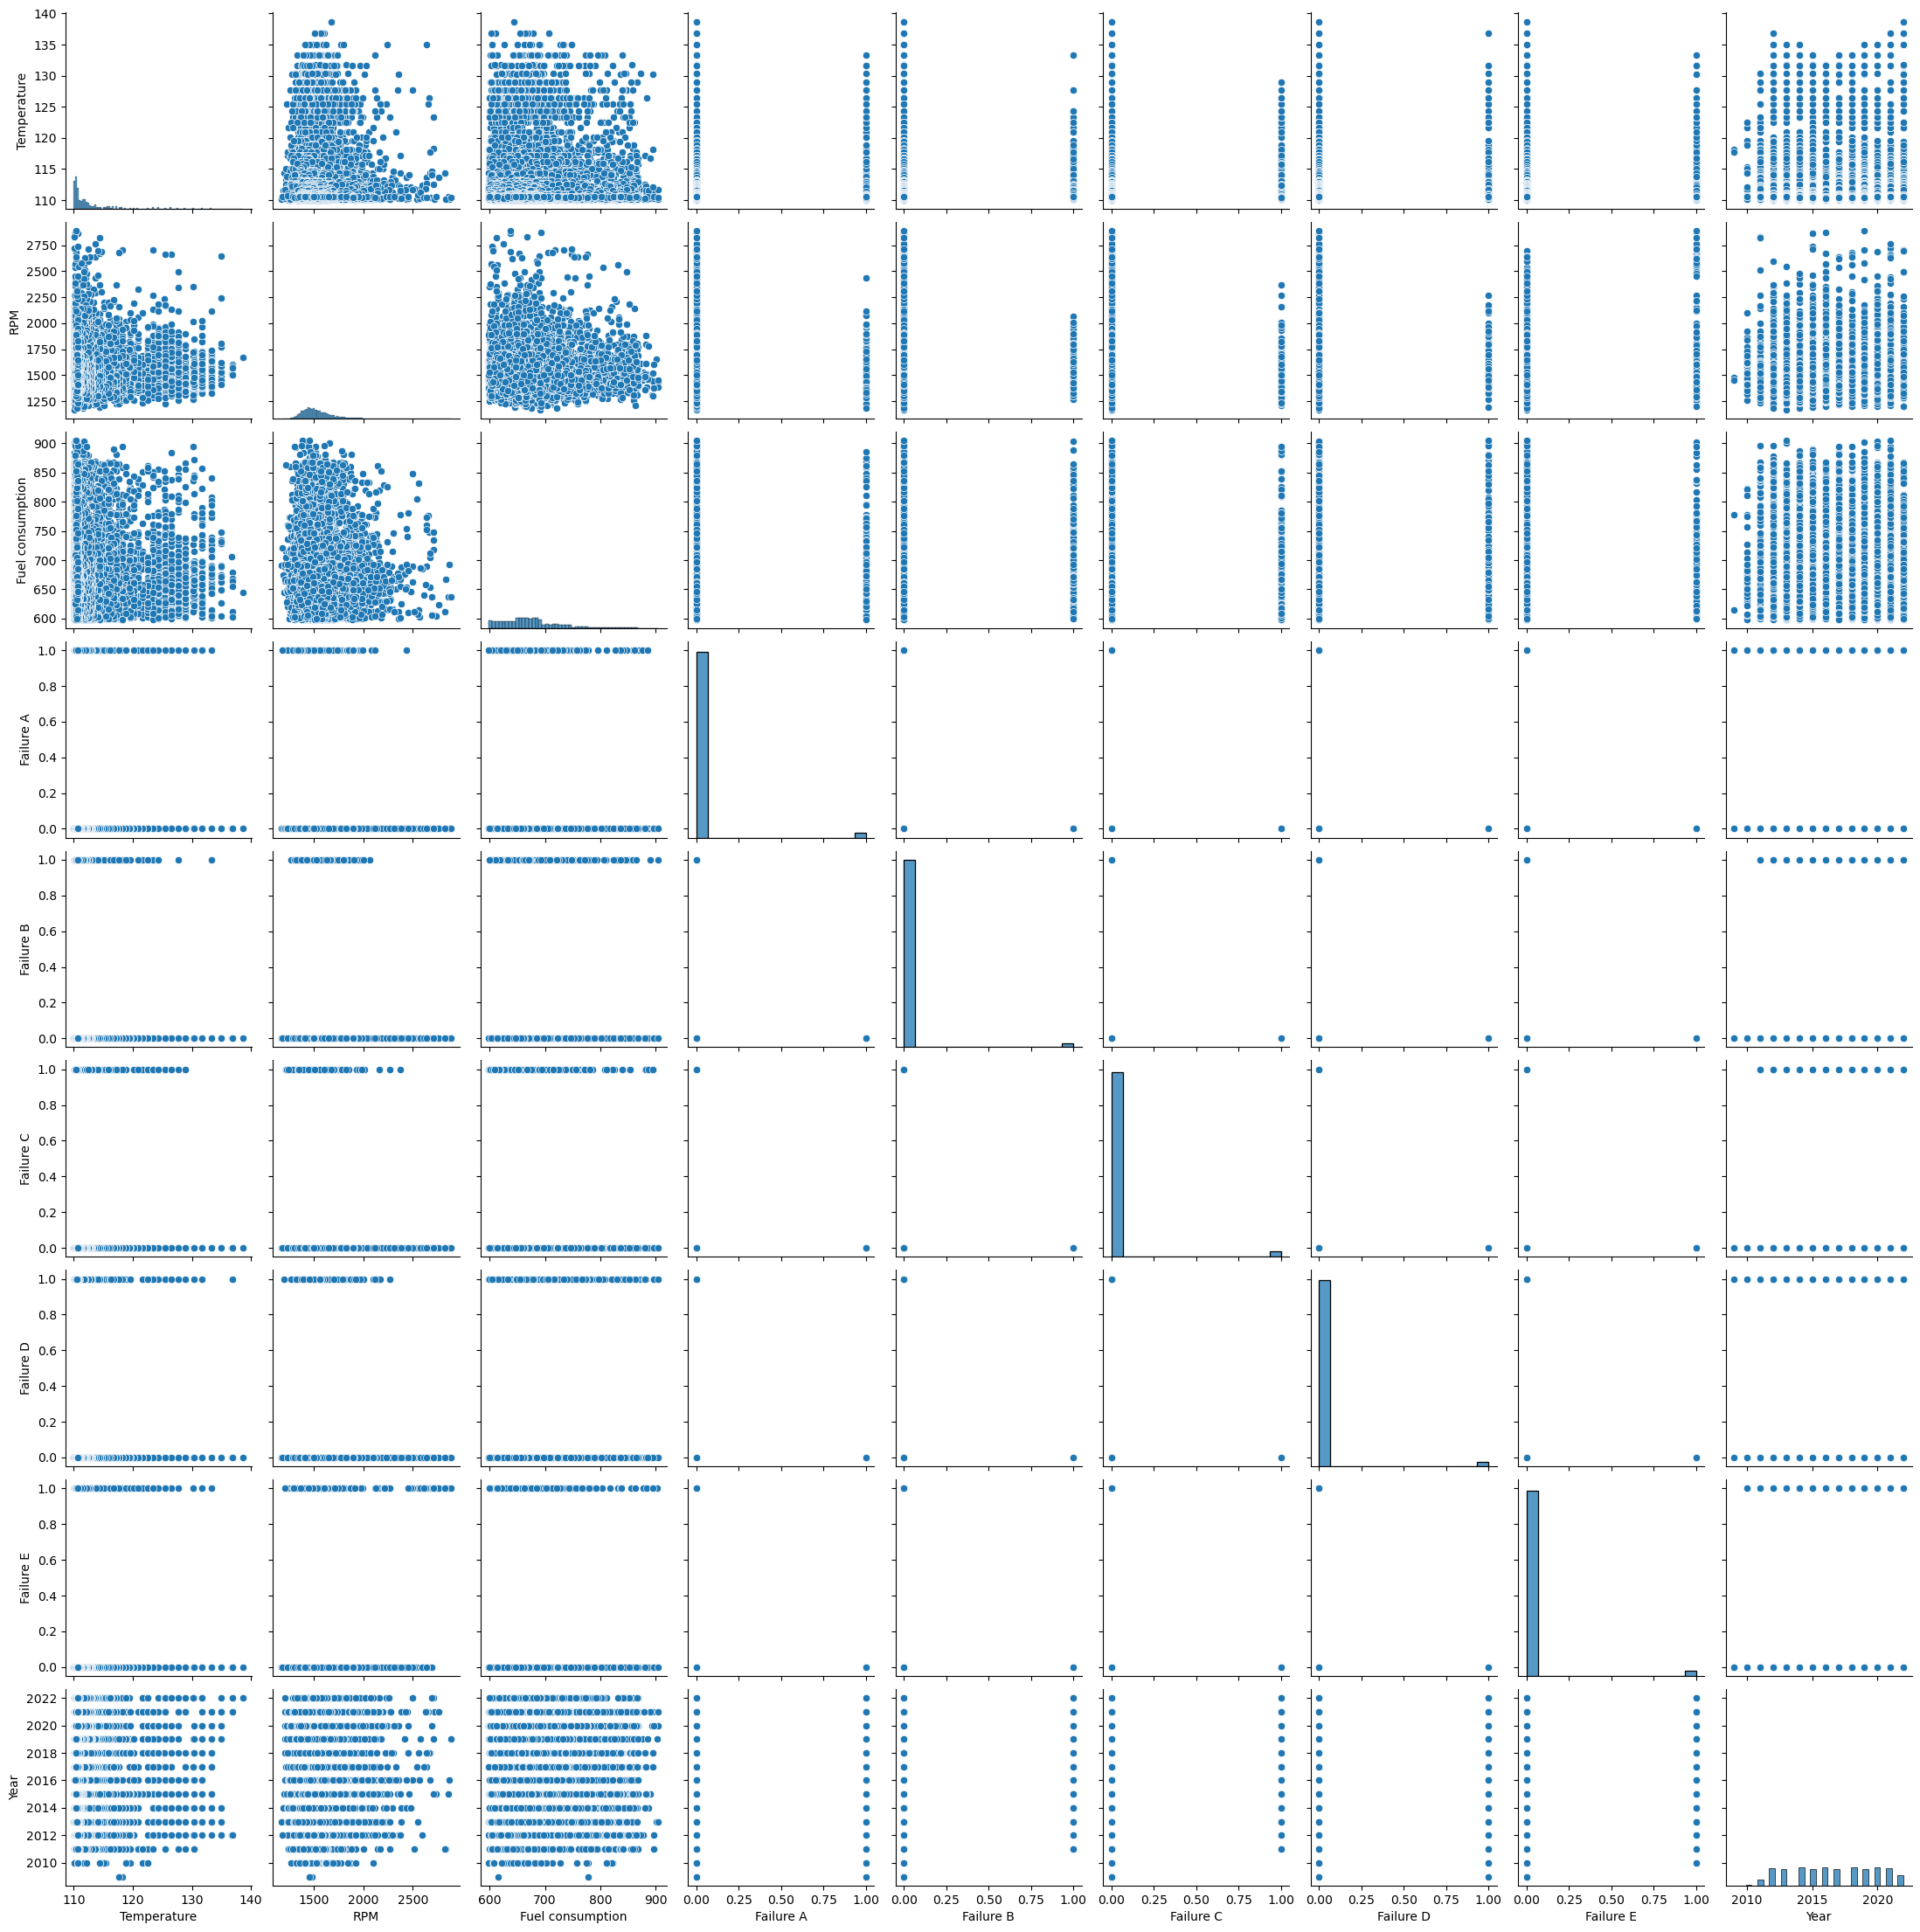

In [90]:
sns.pairplot(df)

/tmp/ipykernel_12816/828436345.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()


<AxesSubplot: >

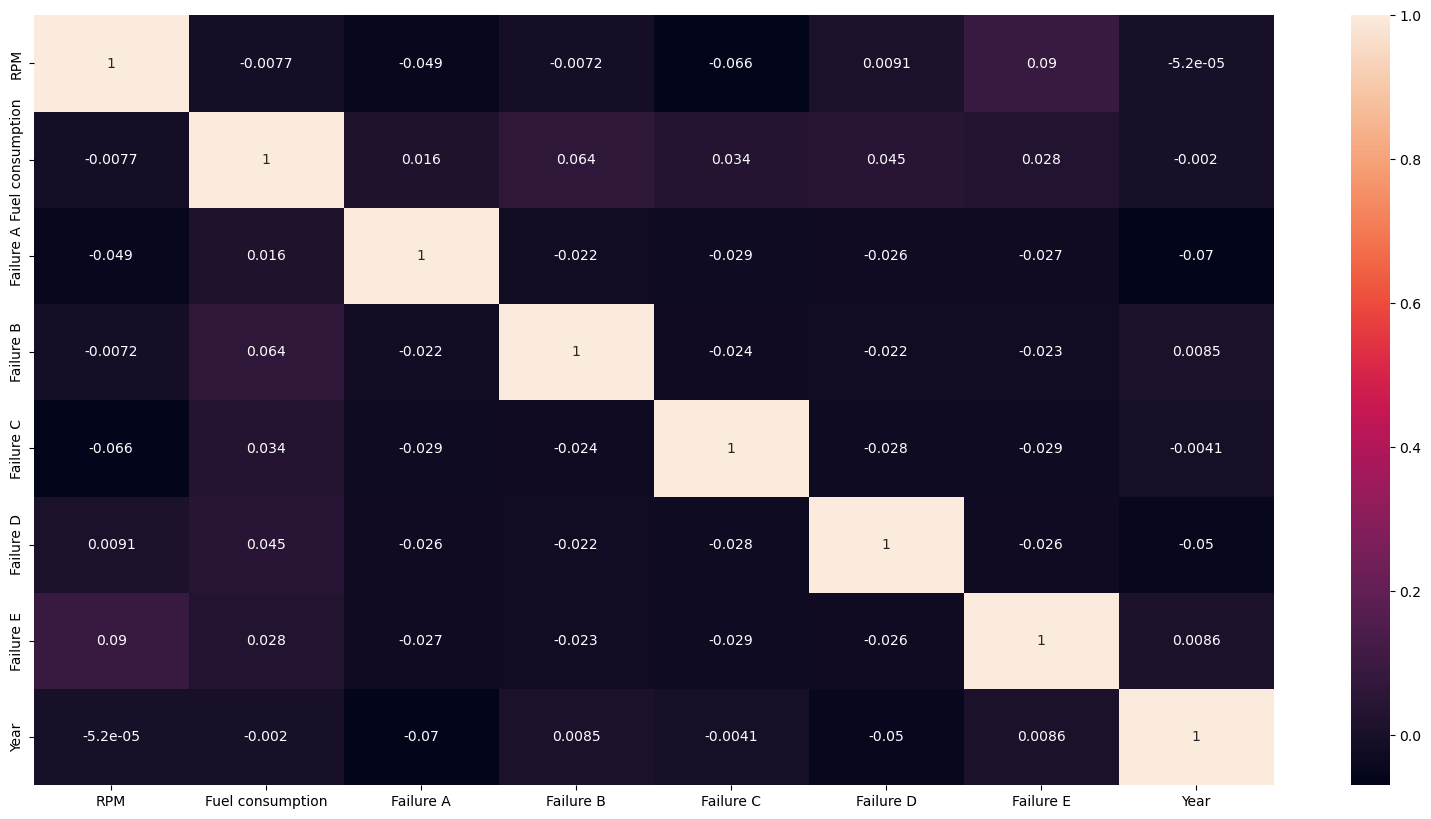

In [91]:
# heatmap
plt.figure(figsize=(20,10))
correlations = df.corr()
sns.heatmap(correlations, annot = True)

all variables seem un-related with each other